In [65]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [66]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import necessary libraries
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPool2D
from sklearn.neighbors import NearestNeighbors
import os
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [8]:
filenames = []
for file in os.listdir('data'):
    filenames.append(os.path.join('data',file))
    

In [9]:
len(filenames)

15437

In [10]:
# Load ResNet50 Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False

# Add GlobalMaxPool2D Layer
model = tf.keras.Sequential([
    model,
    GlobalMaxPool2D()
])

    

In [11]:
# Function to Extract Features
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features


In [12]:
# Batch Processing Function
def batch_extract_features(filenames, model, batch_size=64):
    features = []
    for i in range(0, len(filenames), batch_size):
        batch_files = filenames[i:i+batch_size]
        batch_images = []
        for file in batch_files:
            img = image.load_img(file, target_size=(224, 224))
            img_array = image.img_to_array(img)
            batch_images.append(img_array)
        batch_images = np.array(batch_images)
        preprocessed_batch = preprocess_input(batch_images)
        batch_features = model.predict(preprocessed_batch)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        batch_features = batch_features / norm(batch_features, axis=1, keepdims=True)
        features.extend(batch_features)
    return np.array(features)

In [13]:
# Extract and Save Features
features = batch_extract_features(filenames, model)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
# Save Features and Filenames
with open('Images_features.pkl', 'wb') as f:
    pkl.dump(features, f)
with open('filenames.pkl', 'wb') as f:
    pkl.dump(filenames, f)

In [15]:
# Load Features and Filenames
with open('Images_features.pkl', 'rb') as f:
    features = pkl.load(f)
with open('filenames.pkl', 'rb') as f:
    filenames = pkl.load(f)


In [16]:
# Fit Nearest Neighbors Model with a dynamic number of neighbors
n_samples = len(features)
n_neighbors = min(5, n_samples)  # Ensure n_neighbors is not greater than the number of samples
neighbors = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='euclidean')
neighbors.fit(features)


NearestNeighbors(algorithm='brute', metric='euclidean')

In [17]:
# Find Similar Images
input_image = extract_features('data/1525.jpg', model)
distances, indices = neighbors.kneighbors([input_image])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


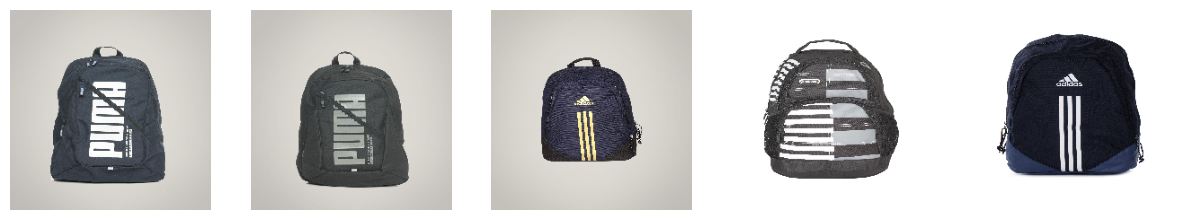

In [18]:
# Display Similar Images
plt.figure(figsize=(15, 15))  # Adjust the figure size if needed
for i in range(n_neighbors):
    plt.subplot(1, n_neighbors, i+1)
    img = image.load_img(filenames[indices[0][i]], target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
plt.show()